# Method 6 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

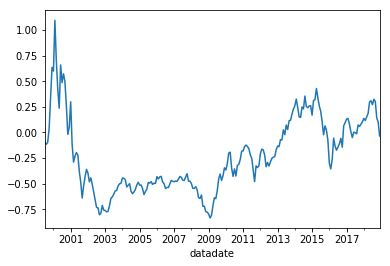

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.634009
2000-12-31   -0.355719
2001-12-31   -0.392443
2002-12-31   -0.621147
2003-12-31    1.077198
2004-12-31    0.022123
2005-12-31   -0.023306
2006-12-31    0.043072
2007-12-31    0.001450
2008-12-31   -0.574573
2009-12-31    1.931079
2010-12-31    0.249947
2011-12-31   -0.174465
2012-12-31    0.229617
2013-12-31    0.478992
2014-12-31    0.027035
2015-12-31   -0.268542
2016-12-31    0.187832
2017-12-31    0.006237
2018-12-31   -0.124547
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     199.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-73
Time:                        14:12:37   Log-Likelihood:                 339.23
No. Observations:                 234   AIC:                            -668.5
Df Residuals:                     229   BIC:                            -651.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.004      0.962      0.337      -0.004       0.011
mktrf          1.3838      0.107     12.928      0.000       1.173       1.595
me             0.8050      0.125      6.465      0.000       0.560       1.050
ia            -0.1216      0.189     -0.642      0.521      -0.494       0.251
roe           -1.4447      0.162     -8.919      0.000      -1.764      -1.126
==============================================================================
Omnibus:                      126.242   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1155.139
Skew:                           1.916   Prob(JB):                    1.46e-251
Kurtosis:                      13.188   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     109.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.57e-52
Time:                        14:12:37   Log-Likelihood:                 339.23
No. Observations:                 234   AIC:                            -668.5
Df Residuals:                     229   BIC:                            -651.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.004      0.949      0.343      -0.004       0.012
mktrf          1.3838      0.194      7.146      0.000       1.004       1.763
me             0.8050      0.145      5.536      0.000       0.520       1.090
ia            -0.1216      0.248     -0.490      0.624      -0.608       0.365
roe           -1.4447      0.246     -5.884      0.000      -1.926      -0.963
==============================================================================
Omnibus:                      126.242   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1155.139
Skew:                           1.916   Prob(JB):                    1.46e-251
Kurtosis:                      13.188   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     152.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.11e-63
Time:                        14:12:37   Log-Likelihood:                 339.23
No. Observations:                 234   AIC:                            -668.5
Df Residuals:                     229   BIC:                            -651.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.004      0.893      0.372      -0.004       0.012
mktrf          1.3838      0.190      7.283      0.000       1.011       1.756
me             0.8050      0.154      5.227      0.000       0.503       1.107
ia            -0.1216      0.234     -0.520      0.603      -0.580       0.337
roe           -1.4447      0.261     -5.536      0.000      -1.956      -0.933
==============================================================================
Omnibus:                      126.242   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1155.139
Skew:                           1.916   Prob(JB):                    1.46e-251
Kurtosis:                      13.188   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     147.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.06e-69
Time:                        14:12:37   Log-Likelihood:                 332.39
No. Observations:                 234   AIC:                            -652.8
Df Residuals:                     228   BIC:                            -632.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.004      0.665      0.507      -0.005       0.011
mktrf          1.5371      0.111     13.889      0.000       1.319       1.755
smb            0.8336      0.146      5.708      0.000       0.546       1.121
hml            0.0891      0.172      0.518      0.605      -0.250       0.428
rmw           -1.3157      0.195     -6.758      0.000      -1.699      -0.932
cma            0.0511      0.247      0.207      0.837      -0.437       0.539
==============================================================================
Omnibus:                      123.025   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              811.720
Skew:                           1.990   Prob(JB):                    5.46e-177
Kurtosis:                      11.211   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     104.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.32e-57
Time:                        14:12:37   Log-Likelihood:                 332.39
No. Observations:                 234   AIC:                            -652.8
Df Residuals:                     228   BIC:                            -632.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.004      0.681      0.496      -0.005       0.011
mktrf          1.5371      0.136     11.322      0.000       1.271       1.803
smb            0.8336      0.149      5.578      0.000       0.541       1.126
hml            0.0891      0.265      0.336      0.737      -0.431       0.609
rmw           -1.3157      0.233     -5.643      0.000      -1.773      -0.859
cma            0.0511      0.301      0.170      0.865      -0.539       0.641
==============================================================================
Omnibus:                      123.025   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              811.720
Skew:                           1.990   Prob(JB):                    5.46e-177
Kurtosis:                      11.211   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     102.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.73e-56
Time:                        14:12:37   Log-Likelihood:                 332.39
No. Observations:                 234   AIC:                            -652.8
Df Residuals:                     228   BIC:                            -632.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.004      0.638      0.523      -0.006       0.011
mktrf          1.5371      0.125     12.287      0.000       1.292       1.782
smb            0.8336      0.145      5.754      0.000       0.550       1.118
hml            0.0891      0.216      0.413      0.680      -0.334       0.512
rmw           -1.3157      0.246     -5.357      0.000      -1.797      -0.834
cma            0.0511      0.251      0.204      0.838      -0.440       0.542
==============================================================================
Omnibus:                      123.025   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              811.720
Skew:                           1.990   Prob(JB):                    5.46e-177
Kurtosis:                      11.211   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     185.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-70
Time:                        14:12:37   Log-Likelihood:                 332.39
No. Observations:                 234   AIC:                            -654.8
Df Residuals:                     229   BIC:                            -637.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.004     -0.250      0.803      -0.009       0.007
mktrf          1.6119      0.101     15.885      0.000       1.412       1.812
smb            1.4635      0.127     11.554      0.000       1.214       1.713
hml           -0.2019      0.126     -1.604      0.110      -0.450       0.046
umd           -0.5206      0.083     -6.306      0.000      -0.683      -0.358
==============================================================================
Omnibus:                      107.411   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.461
Skew:                           1.676   Prob(JB):                    1.07e-153
Kurtosis:                      10.811   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     76.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.98e-41
Time:                        14:12:37   Log-Likelihood:                 332.39
No. Observations:                 234   AIC:                            -654.8
Df Residuals:                     229   BIC:                            -637.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.004     -0.259      0.796      -0.008       0.006
mktrf          1.6119      0.158     10.219      0.000       1.303       1.921
smb            1.4635      0.141     10.393      0.000       1.188       1.740
hml           -0.2019      0.203     -0.997      0.319      -0.599       0.195
umd           -0.5206      0.140     -3.727      0.000      -0.794      -0.247
==============================================================================
Omnibus:                      107.411   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.461
Skew:                           1.676   Prob(JB):                    1.07e-153
Kurtosis:                      10.811   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     95.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.61e-48
Time:                        14:12:37   Log-Likelihood:                 332.39
No. Observations:                 234   AIC:                            -654.8
Df Residuals:                     229   BIC:                            -637.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.004     -0.253      0.801      -0.009       0.007
mktrf          1.6119      0.150     10.714      0.000       1.317       1.907
smb            1.4635      0.121     12.105      0.000       1.227       1.700
hml           -0.2019      0.185     -1.090      0.276      -0.565       0.161
umd           -0.5206      0.142     -3.658      0.000      -0.800      -0.242
==============================================================================
Omnibus:                      107.411   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.461
Skew:                           1.676   Prob(JB):                    1.07e-153
Kurtosis:                      10.811   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     99.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-36
Time:                        14:12:37   Log-Likelihood:                 155.16
No. Observations:                 120   AIC:                            -300.3
Df Residuals:                     115   BIC:                            -286.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.006      1.018      0.311      -0.006       0.019
mktrf          1.3001      0.175      7.435      0.000       0.954       1.646
me             0.7732      0.173      4.477      0.000       0.431       1.115
ia            -0.4070      0.270     -1.505      0.135      -0.943       0.129
roe           -1.3804      0.239     -5.767      0.000      -1.855      -0.906
==============================================================================
Omnibus:                       65.472   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.686
Skew:                           1.800   Prob(JB):                     1.17e-76
Kurtosis:                      10.548   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     89.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.82e-34
Time:                        14:12:37   Log-Likelihood:                 155.16
No. Observations:                 120   AIC:                            -300.3
Df Residuals:                     115   BIC:                            -286.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.006      1.097      0.273      -0.005       0.018
mktrf          1.3001      0.305      4.258      0.000       0.702       1.899
me             0.7732      0.195      3.972      0.000       0.392       1.155
ia            -0.4070      0.336     -1.211      0.226      -1.066       0.252
roe           -1.3804      0.341     -4.051      0.000      -2.048      -0.713
==============================================================================
Omnibus:                       65.472   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.686
Skew:                           1.800   Prob(JB):                     1.17e-76
Kurtosis:                      10.548   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     157.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-45
Time:                        14:12:37   Log-Likelihood:                 155.16
No. Observations:                 120   AIC:                            -300.3
Df Residuals:                     115   BIC:                            -286.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.006      1.095      0.274      -0.005       0.018
mktrf          1.3001      0.307      4.231      0.000       0.698       1.902
me             0.7732      0.204      3.790      0.000       0.373       1.173
ia            -0.4070      0.289     -1.406      0.160      -0.974       0.160
roe           -1.3804      0.379     -3.640      0.000      -2.124      -0.637
==============================================================================
Omnibus:                       65.472   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.686
Skew:                           1.800   Prob(JB):                     1.17e-76
Kurtosis:                      10.548   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     78.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.26e-35
Time:                        14:12:37   Log-Likelihood:                 155.08
No. Observations:                 120   AIC:                            -298.2
Df Residuals:                     114   BIC:                            -281.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.007      1.005      0.317      -0.007       0.020
mktrf          1.6586      0.185      8.950      0.000       1.291       2.026
smb            0.8909      0.210      4.245      0.000       0.475       1.307
hml           -0.3611      0.257     -1.404      0.163      -0.871       0.148
rmw           -0.9060      0.303     -2.987      0.003      -1.507      -0.305
cma            0.1018      0.332      0.306      0.760      -0.556       0.760
==============================================================================
Omnibus:                       72.322   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.896
Skew:                           2.107   Prob(JB):                     2.85e-76
Kurtosis:                      10.199   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     65.70
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.76e-32
Time:                        14:12:37   Log-Likelihood:                 155.08
No. Observations:                 120   AIC:                            -298.2
Df Residuals:                     114   BIC:                            -281.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.005      1.308      0.191      -0.003       0.017
mktrf          1.6586      0.246      6.730      0.000       1.176       2.142
smb            0.8909      0.211      4.219      0.000       0.477       1.305
hml           -0.3611      0.192     -1.881      0.060      -0.737       0.015
rmw           -0.9060      0.315     -2.874      0.004      -1.524      -0.288
cma            0.1018      0.343      0.297      0.766      -0.570       0.774
==============================================================================
Omnibus:                       72.322   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.896
Skew:                           2.107   Prob(JB):                     2.85e-76
Kurtosis:                      10.199   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     74.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.89e-34
Time:                        14:12:37   Log-Likelihood:                 155.08
No. Observations:                 120   AIC:                            -298.2
Df Residuals:                     114   BIC:                            -281.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.005      1.270      0.204      -0.004       0.017
mktrf          1.6586      0.208      7.957      0.000       1.250       2.067
smb            0.8909      0.194      4.592      0.000       0.511       1.271
hml           -0.3611      0.138     -2.622      0.009      -0.631      -0.091
rmw           -0.9060      0.335     -2.704      0.007      -1.563      -0.249
cma            0.1018      0.273      0.373      0.709      -0.434       0.637
==============================================================================
Omnibus:                       72.322   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.896
Skew:                           2.107   Prob(JB):                     2.85e-76
Kurtosis:                      10.199   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     112.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.91e-39
Time:                        14:12:37   Log-Likelihood:                 160.81
No. Observations:                 120   AIC:                            -311.6
Df Residuals:                     115   BIC:                            -297.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.006      0.528      0.598      -0.009       0.015
mktrf          1.6282      0.147     11.080      0.000       1.337       1.919
smb            1.4127      0.167      8.443      0.000       1.081       1.744
hml           -0.5128      0.168     -3.060      0.003      -0.845      -0.181
umd           -0.4790      0.103     -4.636      0.000      -0.684      -0.274
==============================================================================
Omnibus:                       63.294   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              333.953
Skew:                           1.729   Prob(JB):                     3.04e-73
Kurtosis:                      10.405   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     86.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.41e-34
Time:                        14:12:37   Log-Likelihood:                 160.81
No. Observations:                 120   AIC:                            -311.6
Df Residuals:                     115   BIC:                            -297.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.005      0.612      0.540      -0.007       0.013
mktrf          1.6282      0.225      7.240      0.000       1.187       2.069
smb            1.4127      0.158      8.918      0.000       1.102       1.723
hml           -0.5128      0.238     -2.151      0.031      -0.980      -0.046
umd           -0.4790      0.156     -3.068      0.002      -0.785      -0.173
==============================================================================
Omnibus:                       63.294   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              333.953
Skew:                           1.729   Prob(JB):                     3.04e-73
Kurtosis:                      10.405   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     219.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.09e-53
Time:                        14:12:37   Log-Likelihood:                 160.81
No. Observations:                 120   AIC:                            -311.6
Df Residuals:                     115   BIC:                            -297.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.005      0.633      0.526      -0.007       0.013
mktrf          1.6282      0.216      7.531      0.000       1.204       2.052
smb            1.4127      0.130     10.876      0.000       1.158       1.667
hml           -0.5128      0.195     -2.635      0.008      -0.894      -0.131
umd           -0.4790      0.164     -2.914      0.004      -0.801      -0.157
==============================================================================
Omnibus:                       63.294   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              333.953
Skew:                           1.729   Prob(JB):                     3.04e-73
Kurtosis:                      10.405   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     107.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.95e-37
Time:                        14:12:37   Log-Likelihood:                 198.49
No. Observations:                 114   AIC:                            -387.0
Df Residuals:                     109   BIC:                            -373.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.004      0.164      0.870      -0.008       0.009
mktrf          1.4902      0.128     11.683      0.000       1.237       1.743
me             0.7721      0.197      3.920      0.000       0.382       1.162
ia             0.3692      0.273      1.352      0.179      -0.172       0.911
roe           -1.6893      0.240     -7.038      0.000      -2.165      -1.214
==============================================================================
Omnibus:                       17.792   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.018
Skew:                           0.707   Prob(JB):                     5.00e-07
Kurtosis:                       5.027   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     83.08
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.34e-32
Time:                        14:12:37   Log-Likelihood:                 198.49
No. Observations:                 114   AIC:                            -387.0
Df Residuals:                     109   BIC:                            -373.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.206      0.837      -0.006       0.007
mktrf          1.4902      0.172      8.684      0.000       1.154       1.827
me             0.7721      0.278      2.773      0.006       0.226       1.318
ia             0.3692      0.305      1.209      0.227      -0.229       0.968
roe           -1.6893      0.386     -4.372      0.000      -2.447      -0.932
==============================================================================
Omnibus:                       17.792   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.018
Skew:                           0.707   Prob(JB):                     5.00e-07
Kurtosis:                       5.027   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     96.85
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.70e-35
Time:                        14:12:37   Log-Likelihood:                 198.49
No. Observations:                 114   AIC:                            -387.0
Df Residuals:                     109   BIC:                            -373.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.220      0.826      -0.006       0.007
mktrf          1.4902      0.163      9.163      0.000       1.171       1.809
me             0.7721      0.316      2.441      0.015       0.152       1.392
ia             0.3692      0.325      1.136      0.256      -0.268       1.006
roe           -1.6893      0.392     -4.312      0.000      -2.457      -0.921
==============================================================================
Omnibus:                       17.792   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.018
Skew:                           0.707   Prob(JB):                     5.00e-07
Kurtosis:                       5.027   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     78.91
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.89e-34
Time:                        14:12:37   Log-Likelihood:                 194.92
No. Observations:                 114   AIC:                            -377.8
Df Residuals:                     108   BIC:                            -361.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.004     -0.389      0.698      -0.011       0.007
mktrf          1.5319      0.126     12.149      0.000       1.282       1.782
smb            0.7175      0.205      3.505      0.001       0.312       1.123
hml            0.7540      0.261      2.888      0.005       0.237       1.272
rmw           -1.5190      0.320     -4.752      0.000      -2.153      -0.885
cma           -0.0410      0.406     -0.101      0.920      -0.845       0.763
==============================================================================
Omnibus:                       17.833   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.373
Skew:                           0.504   Prob(JB):                     8.52e-11
Kurtosis:                       5.958   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     75.85
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.89e-34
Time:                        14:12:37   Log-Likelihood:                 194.92
No. Observations:                 114   AIC:                            -377.8
Df Residuals:                     108   BIC:                            -361.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.004     -0.397      0.692      -0.010       0.007
mktrf          1.5319      0.131     11.708      0.000       1.275       1.788
smb            0.7175      0.239      3.001      0.003       0.249       1.186
hml            0.7540      0.224      3.363      0.001       0.315       1.193
rmw           -1.5190      0.381     -3.983      0.000      -2.266      -0.772
cma           -0.0410      0.337     -0.122      0.903      -0.701       0.619
==============================================================================
Omnibus:                       17.833   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.373
Skew:                           0.504   Prob(JB):                     8.52e-11
Kurtosis:                       5.958   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     94.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.41e-38
Time:                        14:12:37   Log-Likelihood:                 194.92
No. Observations:                 114   AIC:                            -377.8
Df Residuals:                     108   BIC:                            -361.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.004     -0.424      0.672      -0.010       0.006
mktrf          1.5319      0.138     11.133      0.000       1.262       1.802
smb            0.7175      0.256      2.800      0.005       0.215       1.220
hml            0.7540      0.193      3.908      0.000       0.376       1.132
rmw           -1.5190      0.343     -4.425      0.000      -2.192      -0.846
cma           -0.0410      0.349     -0.117      0.907      -0.725       0.643
==============================================================================
Omnibus:                       17.833   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.373
Skew:                           0.504   Prob(JB):                     8.52e-11
Kurtosis:                       5.958   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     86.73
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.73e-33
Time:                        14:12:37   Log-Likelihood:                 188.84
No. Observations:                 114   AIC:                            -367.7
Df Residuals:                     109   BIC:                            -354.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.005     -0.617      0.539      -0.012       0.006
mktrf          1.5778      0.132     11.994      0.000       1.317       1.838
smb            1.0768      0.205      5.250      0.000       0.670       1.483
hml            0.7214      0.211      3.415      0.001       0.303       1.140
umd           -0.5197      0.159     -3.261      0.001      -0.836      -0.204
==============================================================================
Omnibus:                       22.281   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.732
Skew:                           0.629   Prob(JB):                     8.78e-15
Kurtosis:                       6.471   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     99.64
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.70e-35
Time:                        14:12:37   Log-Likelihood:                 188.84
No. Observations:                 114   AIC:                            -367.7
Df Residuals:                     109   BIC:                            -354.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.004     -0.671      0.502      -0.011       0.006
mktrf          1.5778      0.148     10.643      0.000       1.287       1.868
smb            1.0768      0.242      4.453      0.000       0.603       1.551
hml            0.7214      0.245      2.946      0.003       0.241       1.201
umd           -0.5197      0.129     -4.043      0.000      -0.772      -0.268
==============================================================================
Omnibus:                       22.281   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.732
Skew:                           0.629   Prob(JB):                     8.78e-15
Kurtosis:                       6.471   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     121.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.48e-39
Time:                        14:12:37   Log-Likelihood:                 188.84
No. Observations:                 114   AIC:                            -367.7
Df Residuals:                     109   BIC:                            -354.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.004     -0.693      0.488      -0.011       0.005
mktrf          1.5778      0.150     10.485      0.000       1.283       1.873
smb            1.0768      0.229      4.707      0.000       0.628       1.525
hml            0.7214      0.247      2.926      0.003       0.238       1.205
umd           -0.5197      0.113     -4.611      0.000      -0.741      -0.299
==============================================================================
Omnibus:                       22.281   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.732
Skew:                           0.629   Prob(JB):                     8.78e-15
Kurtosis:                       6.471   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""